In [1]:
# ============================================
# 0. INSTALLS (run once per session)
# ============================================
!pip install -q "transformers>=4.46.0" "mistral_common[audio]>=1.8.6" "accelerate>=0.34.0" \
               einops pandas soundfile seaborn


In [2]:
# ============================================
# 1. IMPORTS & DEVICE
# ============================================
import os, json
from typing import Optional, List

import numpy as np
import pandas as pd
import soundfile as sf
from tqdm.auto import tqdm

import torch
from transformers import VoxtralForConditionalGeneration, AutoProcessor

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    cohen_kappa_score,
    matthews_corrcoef,
)

import matplotlib.pyplot as plt
import seaborn as sns

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [3]:
# ============================================
# 2. MOUNT DRIVE & DEFINE PATHS
# ============================================
from google.colab import drive
drive.mount("/content/drive")

BASE = "/content/drive/MyDrive/adsp"   # adjust ONLY if your 'adsp' folder is elsewhere

EMOBOX_ROOT    = os.path.join(BASE, "EmoBox")
IEMOCAP_EMOBOX = os.path.join(EMOBOX_ROOT, "data", "iemocap")
IEMOCAP_RAW    = os.path.join(BASE, "downloads", "iemocap")
TRANSCRIPT_CSV = os.path.join(IEMOCAP_RAW, "txt", "iemocap_transcriptions.csv")

FOLD_ID = 1  # which EmoBox test fold to use (1..5)
TEST_JSON = os.path.join(
    IEMOCAP_EMOBOX, f"fold_{FOLD_ID}", f"iemocap_test_fold_{FOLD_ID}.json"
)

print("EMOBOX_ROOT   :", EMOBOX_ROOT)
print("IEMOCAP_EMOBOX:", IEMOCAP_EMOBOX)
print("IEMOCAP_RAW   :", IEMOCAP_RAW)
print("TRANSCRIPT_CSV:", TRANSCRIPT_CSV)
print("TEST_JSON     :", TEST_JSON)

for p in [EMOBOX_ROOT, IEMOCAP_EMOBOX, IEMOCAP_RAW, TRANSCRIPT_CSV, TEST_JSON]:
    assert os.path.exists(p), f"Missing path: {p}"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
EMOBOX_ROOT   : /content/drive/MyDrive/adsp/EmoBox
IEMOCAP_EMOBOX: /content/drive/MyDrive/adsp/EmoBox/data/iemocap
IEMOCAP_RAW   : /content/drive/MyDrive/adsp/downloads/iemocap
TRANSCRIPT_CSV: /content/drive/MyDrive/adsp/downloads/iemocap/txt/iemocap_transcriptions.csv
TEST_JSON     : /content/drive/MyDrive/adsp/EmoBox/data/iemocap/fold_1/iemocap_test_fold_1.json


In [4]:
# ============================================
# 3. LOAD EMOBOX TEST FOLD (AUDIO + LABELS)
# ============================================
with open(TEST_JSON, "r") as f:
    test_dict = json.load(f)

# test_dict: key -> { 'wav': 'downloads/iemocap/...wav', 'emo': 'ang', ... }
df_test_raw = (
    pd.DataFrame.from_dict(test_dict, orient="index")
      .reset_index()
      .rename(columns={"index": "key"})
)

print("RAW EmoBox test shape:", df_test_raw.shape)
print(df_test_raw.head(3))

# sanity: keys must be unique
assert df_test_raw["key"].is_unique, "Non-unique keys in test JSON."

# build absolute audio paths
def abs_audio(rel_path: str) -> str:
    """
    EmoBox 'wav' looks like:
      'downloads/iemocap/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F000.wav'
    Raw IEMOCAP audio is under:
      BASE/downloads/iemocap/Session1/...
    """
    rel = str(rel_path)
    if rel.startswith("downloads/iemocap/"):
        rel = rel[len("downloads/iemocap/"):]
    return os.path.join(IEMOCAP_RAW, rel)

df_test_raw["audio_path"] = df_test_raw["wav"].astype(str).apply(abs_audio)

df_test = df_test_raw[df_test_raw["audio_path"].apply(os.path.exists)].reset_index(drop=True)
missing = len(df_test_raw) - len(df_test)
print(f"\nAfter audio existence check: kept {len(df_test)} / {len(df_test_raw)} (missing {missing})")
print(df_test[["key", "audio_path", "emo"]].head(3))

# utt_id from wav filename: 'Ses01F_impro04_F000.wav' -> 'Ses01F_impro04_F000'
df_test["utt_id"] = df_test["wav"].apply(lambda p: os.path.splitext(os.path.basename(p))[0])
print(df_test[["key", "utt_id", "emo"]].head(5))


RAW EmoBox test shape: (1085, 6)
                           key  \
0  iemocap-Ses01F_impro04_F000   
1  iemocap-Ses01F_impro04_F001   
2  iemocap-Ses01F_impro04_F005   

                                                 wav    length  emo  dataset  \
0  downloads/iemocap/Session1/sentences/wav/Ses01...  4.394500  neu  iemocap   
1  downloads/iemocap/Session1/sentences/wav/Ses01...  4.405125  neu  iemocap   
2  downloads/iemocap/Session1/sentences/wav/Ses01...  2.409562  neu  iemocap   

   channel  
0        1  
1        1  
2        1  

After audio existence check: kept 1085 / 1085 (missing 0)
                           key  \
0  iemocap-Ses01F_impro04_F000   
1  iemocap-Ses01F_impro04_F001   
2  iemocap-Ses01F_impro04_F005   

                                          audio_path  emo  
0  /content/drive/MyDrive/adsp/downloads/iemocap/...  neu  
1  /content/drive/MyDrive/adsp/downloads/iemocap/...  neu  
2  /content/drive/MyDrive/adsp/downloads/iemocap/...  neu  
                     

In [5]:
# ============================================
# 4. LOAD TRANSCRIPTS & JOIN WITH TEST
# ============================================
df_txt = pd.read_csv(TRANSCRIPT_CSV)
print("Transcript CSV columns:", df_txt.columns.tolist())
print(df_txt.head(5))

assert {"file_name", "transcription"}.issubset(df_txt.columns)

# CSV file_name is already 'Ses01F_impro01_F000'; treat it as utt_id directly
df_txt["utt_id"] = df_txt["file_name"].astype(str)

df_txt = df_txt[["utt_id", "transcription"]].copy()

# inner join: EmoBox test (audio+labels) ∩ transcripts
df = df_test.merge(df_txt, on="utt_id", how="inner")
print("\nRows after joining test with transcripts:", len(df))
assert len(df) > 0, "Join with transcripts produced 0 rows – then something is wrong with ids."

print(df[["utt_id", "audio_path", "emo", "transcription"]].head(5))


Transcript CSV columns: ['file_name', 'transcription']
             file_name            transcription
0  Ses01F_impro01_F000               Excuse me.
1  Ses01F_impro01_M000  Do you have your forms?
2  Ses01F_impro01_F001                    Yeah.
3  Ses01F_impro01_M001         Let me see them.
4  Ses01F_impro01_F002      Is there a problem?

Rows after joining test with transcripts: 1085
                utt_id                                         audio_path  \
0  Ses01F_impro04_F000  /content/drive/MyDrive/adsp/downloads/iemocap/...   
1  Ses01F_impro04_F001  /content/drive/MyDrive/adsp/downloads/iemocap/...   
2  Ses01F_impro04_F005  /content/drive/MyDrive/adsp/downloads/iemocap/...   
3  Ses01F_impro04_F006  /content/drive/MyDrive/adsp/downloads/iemocap/...   
4  Ses01F_impro04_F009  /content/drive/MyDrive/adsp/downloads/iemocap/...   

   emo                                      transcription  
0  neu   Uh, what?  Craig's List?  Oh the internet thing?  
1  neu  I don't know.  Isn

In [6]:
# ============================================
# 4. LOAD TRANSCRIPTS & JOIN WITH TEST
# ============================================
df_txt = pd.read_csv(TRANSCRIPT_CSV)
print("Transcript CSV columns:", df_txt.columns.tolist())
print(df_txt.head(5))

assert {"file_name", "transcription"}.issubset(df_txt.columns)

# CSV file_name is already 'Ses01F_impro01_F000'; treat it as utt_id directly
df_txt["utt_id"] = df_txt["file_name"].astype(str)

df_txt = df_txt[["utt_id", "transcription"]].copy()

# inner join: EmoBox test (audio+labels) ∩ transcripts
df = df_test.merge(df_txt, on="utt_id", how="inner")
print("\nRows after joining test with transcripts:", len(df))
assert len(df) > 0, "Join with transcripts produced 0 rows – then something is wrong with ids."

print(df[["utt_id", "audio_path", "emo", "transcription"]].head(5))


Transcript CSV columns: ['file_name', 'transcription']
             file_name            transcription
0  Ses01F_impro01_F000               Excuse me.
1  Ses01F_impro01_M000  Do you have your forms?
2  Ses01F_impro01_F001                    Yeah.
3  Ses01F_impro01_M001         Let me see them.
4  Ses01F_impro01_F002      Is there a problem?

Rows after joining test with transcripts: 1085
                utt_id                                         audio_path  \
0  Ses01F_impro04_F000  /content/drive/MyDrive/adsp/downloads/iemocap/...   
1  Ses01F_impro04_F001  /content/drive/MyDrive/adsp/downloads/iemocap/...   
2  Ses01F_impro04_F005  /content/drive/MyDrive/adsp/downloads/iemocap/...   
3  Ses01F_impro04_F006  /content/drive/MyDrive/adsp/downloads/iemocap/...   
4  Ses01F_impro04_F009  /content/drive/MyDrive/adsp/downloads/iemocap/...   

   emo                                      transcription  
0  neu   Uh, what?  Craig's List?  Oh the internet thing?  
1  neu  I don't know.  Isn

In [7]:
# ============================================
# 5. LABEL MAPPING  + DEFINE df_eval
# ============================================

# we start from df that already has: ['utt_id', 'audio_path', 'emo', 'transcription']

df["raw_label"] = df["emo"].astype(str).str.lower()

raw2canon = {
    "ang": "anger",
    "hap": "happiness",
    "exc": "happiness",   # excited -> happiness
    "sad": "sadness",
    "neu": "neutral",
}

# keep only the 4 emotions
df = df[df["raw_label"].isin(raw2canon.keys())].reset_index(drop=True)
df["label"] = df["raw_label"].map(raw2canon)

TARGET_LABELS = ["anger", "happiness", "sadness", "neutral"]

print("\nLabel distribution (IEMOCAP test, mapped):")
print(df["label"].value_counts())

# if you want the **full EmoBox test set** → no subsampling
df_eval = df.copy().reset_index(drop=True)

print("\nEval size:", len(df_eval))
print(df_eval["label"].value_counts())



Label distribution (IEMOCAP test, mapped):
label
neutral      384
happiness    278
anger        229
sadness      194
Name: count, dtype: int64

Eval size: 1085
label
neutral      384
happiness    278
anger        229
sadness      194
Name: count, dtype: int64


In [8]:
# ============================================
# 6. LOAD VOXTRAL MODEL (GPU IF AVAILABLE)
# ============================================
import torch
from transformers import VoxtralForConditionalGeneration, AutoProcessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

REPO_ID = "mistralai/Voxtral-Mini-3B-2507"

processor = AutoProcessor.from_pretrained(REPO_ID)
model = VoxtralForConditionalGeneration.from_pretrained(
    REPO_ID,
    torch_dtype=torch.float16 if device.type == "cuda" else torch.float32,
)
model.to(device)
model.eval()

# make sure this exists right after your label-mapping section
LABEL_LIST = ["anger", "happiness", "sadness", "neutral"]


Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
# ============================================
# 7. HELPER: RUN ONE PREDICTION
# ============================================
def normalize_label_from_text(txt: str) -> str:
    """Map Voxtral's free text output back to one of LABEL_LIST."""
    t = txt.strip().lower()

    # direct matches (full word)
    for lab in LABEL_LIST:
        if lab in t:
            return lab

    # some common variants
    if "angry" in t:
        return "anger"
    if "happy" in t:
        return "happiness"
    if "sad" in t:
        return "sadness"
    if "neutral" in t:
        return "neutral"

    # hard fallback – keep evaluation stable
    return "neutral"


def voxtral_predict(audio_path: str,
                    transcript: str | None = None,
                    use_text: bool = False) -> str:
    """
    audio_path : absolute path to wav
    transcript : optional transcript string
    use_text   : if True, use both audio and transcript; else only audio
    returns    : one of LABEL_LIST
    """

    if use_text and transcript is not None and transcript.strip() != "":
        # AUDIO + TRANSCRIPT
        instruction = (
            "You are an emotion classifier for speech. "
            "Use BOTH the audio and the transcript to classify "
            "the speaker's emotion into exactly one of these labels: "
            "anger, happiness, sadness, neutral.\n\n"
            f"Transcript: {transcript}\n\n"
            "Answer with ONLY one word from this set: "
            "anger, happiness, sadness, or neutral."
        )
    else:
        # AUDIO ONLY
        instruction = (
            "You are an emotion classifier for speech. "
            "Based ONLY on the audio, classify the speaker's emotion "
            "into exactly one of these labels: anger, happiness, sadness, neutral.\n\n"
            "Answer with ONLY one word from this set: "
            "anger, happiness, sadness, or neutral."
        )

    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "audio", "path": audio_path},
                {"type": "text",  "text": instruction},
            ],
        }
    ]

    # build model inputs using chat template
    inputs = processor.apply_chat_template(conversation)
    inputs = inputs.to(device, dtype=model.dtype)

    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=8)

    # strip off the prompt tokens
    gen_tokens = outputs[:, inputs.input_ids.shape[1]:]
    decoded = processor.batch_decode(gen_tokens, skip_special_tokens=True)[0]

    return normalize_label_from_text(decoded)


In [10]:
# ============================================
# 8. RUN ZERO-SHOT ON EVAL SET
# ============================================

from tqdm.auto import tqdm

pred_audio   = []
pred_bimodal = []

print("Running zero-shot inference on", len(df_eval), "utterances...")

for _, row in tqdm(df_eval.iterrows(), total=len(df_eval)):
    a_path = row["audio_path"]
    txt    = row.get("transcription", "")

    # audio only
    pa = voxtral_predict(a_path, transcript=None, use_text=False)

    # audio + transcript
    pb = voxtral_predict(a_path, transcript=txt, use_text=True)

    pred_audio.append(pa)
    pred_bimodal.append(pb)

df_eval["pred_audio"]   = pred_audio
df_eval["pred_bimodal"] = pred_bimodal

df_eval.head()


Running zero-shot inference on 1085 utterances...


  0%|          | 0/1085 [00:00<?, ?it/s]

,key,wav,length,emo,dataset,channel,audio_path,utt_id,transcription,raw_label,label,pred_audio,pred_bimodal
0,iemocap-Ses01F_impro04_F000,downloads/iemocap/Session1/sentences/wav/Ses01...,4.394500,neu,iemocap,1,/content/drive/MyDrive/adsp/downloads/iemocap/...,Ses01F_impro04_F000,"Uh, what? Craig's List? Oh the internet thing?",neu,neutral,neutral,neutral
1,iemocap-Ses01F_impro04_F001,downloads/iemocap/Session1/sentences/wav/Ses01...,4.405125,neu,iemocap,1,/content/drive/MyDrive/adsp/downloads/iemocap/...,Ses01F_impro04_F001,I don't know. Isn't that-- that's all like es...,neu,neutral,neutral,neutral
2,iemocap-Ses01F_impro04_F005,downloads/iemocap/Session1/sentences/wav/Ses01...,2.409562,neu,iemocap,1,/content/drive/MyDrive/adsp/downloads/iemocap/...,Ses01F_impro04_F005,He just...,neu,neutral,neutral,neutral
3,iemocap-Ses01F_impro04_F006,downloads/iemocap/Session1/sentences/wav/Ses01...,3.556500,neu,iemocap,1,/content/drive/MyDrive/adsp/downloads/iemocap/...,Ses01F_impro04_F006,you know what? I heard about that job. I app...,neu,neutral,neutral,neutral
4,iemocap-Ses01F_impro04_F009,downloads/iemocap/Session1/sentences/wav/Ses01...,1.383687,neu,iemocap,1,/content/drive/MyDrive/adsp/downloads/iemocap/...,Ses01F_impro04_F009,Yeah.,neu,neutral,neutral,neutral



=== AUDIO ONLY ===
Accuracy:           0.4
Balanced accuracy:  0.30669719629352116
Macro F1:           0.24267331766449113
Weighted F1:        0.28282671632073664
Cohen's kappa:      0.08360297571013042
MCC:                0.1861245887285268

Classification report:
              precision    recall  f1-score   support

       anger       0.85      0.14      0.25       229
   happiness       0.93      0.05      0.09       278
     sadness       0.71      0.05      0.10       194
     neutral       0.37      0.98      0.54       384

    accuracy                           0.40      1085
   macro avg       0.72      0.31      0.24      1085
weighted avg       0.68      0.40      0.28      1085



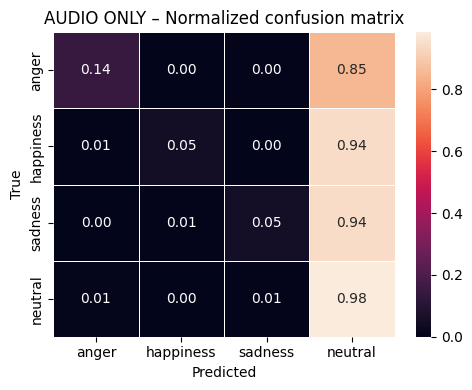


=== AUDIO + TRANSCRIPT ===
Accuracy:           0.44608294930875575
Balanced accuracy:  0.35879669198002695
Macro F1:           0.3317927227350927
Weighted F1:        0.3663086083290025
Cohen's kappa:      0.16371268297812847
MCC:                0.26631130045175

Classification report:
              precision    recall  f1-score   support

       anger       0.91      0.21      0.34       229
   happiness       0.79      0.15      0.25       278
     sadness       0.68      0.10      0.17       194
     neutral       0.39      0.98      0.56       384

    accuracy                           0.45      1085
   macro avg       0.69      0.36      0.33      1085
weighted avg       0.66      0.45      0.37      1085



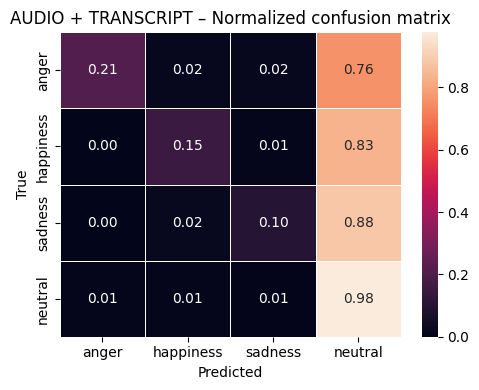

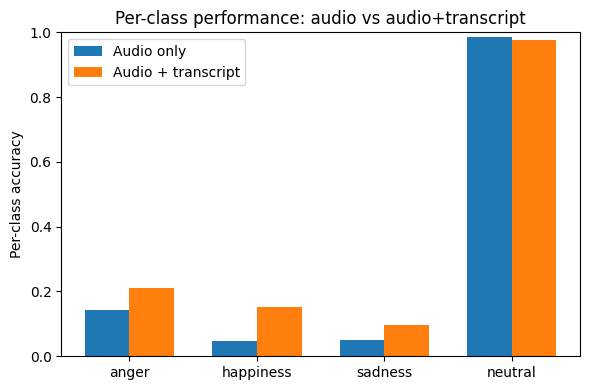

In [11]:
# ============================================
# 9. EVALUATION METRICS
# ============================================
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    cohen_kappa_score,
    matthews_corrcoef,
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_true = df_eval["label"].tolist()
y_a    = df_eval["pred_audio"].tolist()
y_b    = df_eval["pred_bimodal"].tolist()

def compute_metrics(y_true, y_pred, prefix=""):
    print(f"\n=== {prefix} ===")
    print("Accuracy:          ", accuracy_score(y_true, y_pred))
    print("Balanced accuracy: ", balanced_accuracy_score(y_true, y_pred))
    print("Macro F1:          ", f1_score(y_true, y_pred, average="macro"))
    print("Weighted F1:       ", f1_score(y_true, y_pred, average="weighted"))
    print("Cohen's kappa:     ", cohen_kappa_score(y_true, y_pred))
    print("MCC:               ", matthews_corrcoef(y_true, y_pred))
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, labels=LABEL_LIST))

    cm = confusion_matrix(y_true, y_pred, labels=LABEL_LIST)
    cm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f",
        xticklabels=LABEL_LIST,
        yticklabels=LABEL_LIST,
        linewidths=0.5,
    )
    plt.title(f"{prefix} – Normalized confusion matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


compute_metrics(y_true, y_a, prefix="AUDIO ONLY")
compute_metrics(y_true, y_b, prefix="AUDIO + TRANSCRIPT")

# simple per-class comparison bar plot
metrics_per_class = []
for lab in LABEL_LIST:
    idx = df_eval["label"] == lab
    acc_a = accuracy_score(df_eval.loc[idx, "label"], df_eval.loc[idx, "pred_audio"])
    acc_b = accuracy_score(df_eval.loc[idx, "label"], df_eval.loc[idx, "pred_bimodal"])
    metrics_per_class.append((lab, acc_a, acc_b))

labs, acc_a_list, acc_b_list = zip(*metrics_per_class)

x = np.arange(len(labs))
w = 0.35
plt.figure(figsize=(6, 4))
plt.bar(x - w/2, acc_a_list, width=w, label="Audio only")
plt.bar(x + w/2, acc_b_list, width=w, label="Audio + transcript")
plt.xticks(x, labs)
plt.ylim(0, 1)
plt.ylabel("Per-class accuracy")
plt.title("Per-class performance: audio vs audio+transcript")
plt.legend()
plt.tight_layout()
plt.show()


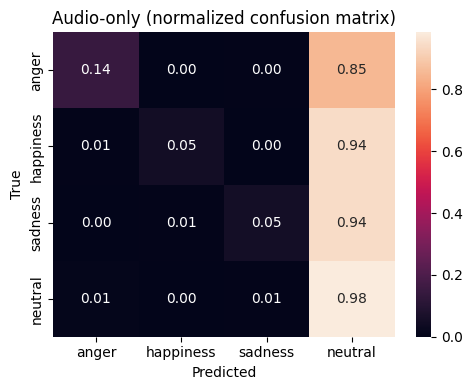

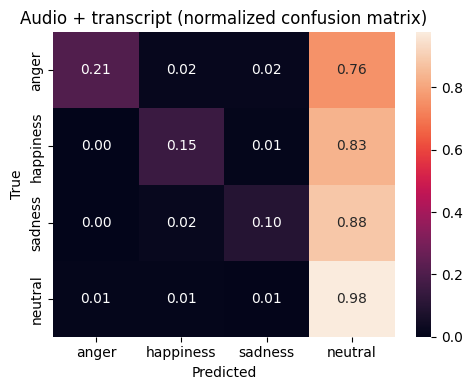

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

LABEL_LIST = ["anger", "happiness", "sadness", "neutral"]

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=LABEL_LIST)
    cm_norm = cm / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt=".2f",
        xticklabels=LABEL_LIST,
        yticklabels=LABEL_LIST,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# here is the important change: use y_a, y_b (or alias them)
y_pred_audio   = y_a
y_pred_bimodal = y_b

plot_cm(y_true, y_pred_audio,   "Audio-only (normalized confusion matrix)")
plot_cm(y_true, y_pred_bimodal, "Audio + transcript (normalized confusion matrix)")


In [19]:
# ============================================
# 11. NEUTRAL-BIAS ANALYSIS (NO LOGITS NEEDED)
# ============================================
import pandas as pd

# y_true, y_a, y_b already defined in the previous cell:
# y_true = df_eval["label"].tolist()
# y_a    = df_eval["pred_audio"].tolist()
# y_b    = df_eval["pred_bimodal"].tolist()

SER_TRUE = pd.Series(y_true, name="true")
SER_A    = pd.Series(y_a,    name="pred_audio")
SER_B    = pd.Series(y_b,    name="pred_bimodal")

print("Label distribution (ground truth):")
print(SER_TRUE.value_counts(), "\n")

print("Prediction distribution – AUDIO ONLY:")
print(SER_A.value_counts(), "\n")

print("Prediction distribution – AUDIO + TRANSCRIPT:")
print(SER_B.value_counts(), "\n")

# how often "neutral" is predicted in each setup
for name, ser in [("AUDIO ONLY", SER_A), ("AUDIO+TRANSCRIPT", SER_B)]:
    total = len(ser)
    neu   = (ser == "neutral").sum()
    print(f"{name}: neutral predictions = {neu}/{total} ({neu/total:.3f})")


Label distribution (ground truth):
true
neutral      384
happiness    278
anger        229
sadness      194
Name: count, dtype: int64 

Prediction distribution – AUDIO ONLY:
pred_audio
neutral      1018
anger          39
sadness        14
happiness      14
Name: count, dtype: int64 

Prediction distribution – AUDIO + TRANSCRIPT:
pred_bimodal
neutral      951
anger         53
happiness     53
sadness       28
Name: count, dtype: int64 

AUDIO ONLY: neutral predictions = 1018/1085 (0.938)
AUDIO+TRANSCRIPT: neutral predictions = 951/1085 (0.876)


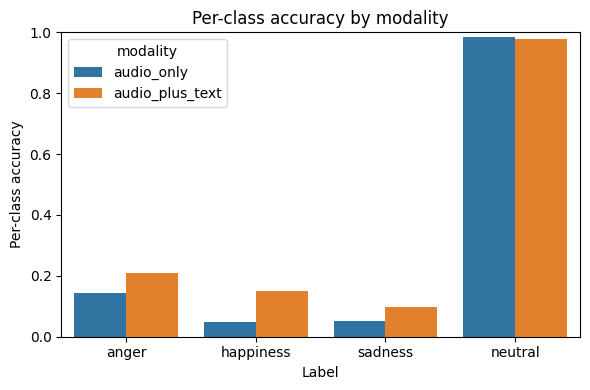

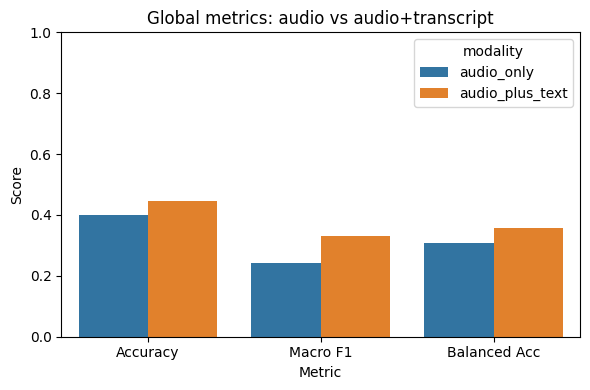

In [20]:
# ============================================
# 11. PER-CLASS ACCURACY & GLOBAL METRIC COMPARISON
# ============================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score

# y_true, y_a, y_b already defined in previous cell
# LABEL_LIST = ["anger", "happiness", "sadness", "neutral"]

def per_label_accuracy(y_true, y_pred, labels):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    accs = {}
    for lab in labels:
        mask = (y_true == lab)
        if mask.sum() == 0:
            accs[lab] = np.nan
        else:
            accs[lab] = (y_pred[mask] == y_true[mask]).mean()
    return accs

# per-class accuracy for the two modalities
acc_audio = per_label_accuracy(y_true, y_a, LABEL_LIST)
acc_both  = per_label_accuracy(y_true, y_b, LABEL_LIST)

df_acc = pd.DataFrame({
    "label": LABEL_LIST,
    "audio_only":   [acc_audio[l] for l in LABEL_LIST],
    "audio_plus_text": [acc_both[l] for l in LABEL_LIST],
})

df_acc_melt = df_acc.melt(id_vars="label",
                          var_name="modality",
                          value_name="accuracy")

plt.figure(figsize=(6, 4))
sns.barplot(data=df_acc_melt, x="label", y="accuracy", hue="modality")
plt.ylim(0, 1)
plt.xlabel("Label")
plt.ylabel("Per-class accuracy")
plt.title("Per-class accuracy by modality")
plt.tight_layout()
plt.show()

# -------- Global metric comparison (Accuracy, Macro F1, Balanced Acc) --------

def global_scores(y_true, y_pred):
    return {
        "Accuracy":   accuracy_score(y_true, y_pred),
        "Macro F1":   f1_score(y_true, y_pred, average="macro"),
        "Balanced Acc": balanced_accuracy_score(y_true, y_pred),
    }

scores_audio = global_scores(y_true, y_a)
scores_both  = global_scores(y_true, y_b)

df_scores = pd.DataFrame({
    "metric": list(scores_audio.keys()),
    "audio_only":   list(scores_audio.values()),
    "audio_plus_text": list(scores_both.values()),
})

df_scores_melt = df_scores.melt(id_vars="metric",
                                var_name="modality",
                                value_name="score")

plt.figure(figsize=(6, 4))
sns.barplot(data=df_scores_melt, x="metric", y="score", hue="modality")
plt.ylim(0, 1)
plt.xlabel("Metric")
plt.ylabel("Score")
plt.title("Global metrics: audio vs audio+transcript")
plt.tight_layout()
plt.show()


In [14]:
# ============================================
# 12. ERROR ANALYSIS (IMPROVED / WORSENED BY TEXT)
# ============================================
df_eval["correct_audio"] = df_eval["pred_audio"]   == df_eval["label"]
df_eval["correct_both"]  = df_eval["pred_bimodal"] == df_eval["label"]

improved = df_eval[(~df_eval["correct_audio"]) & (df_eval["correct_both"])]
worsened = df_eval[(df_eval["correct_audio"]) & (~df_eval["correct_both"])]

print("\n# samples where transcript FIXED an error:", len(improved))
print(improved["label"].value_counts())

print("\n# samples where transcript BROKE a correct prediction:", len(worsened))
print(worsened["label"].value_counts())

print("\nExamples improved by text (first 10):")
print(improved[["utt_id", "label", "pred_audio", "pred_bimodal"]].head(10))

print("\nExamples worsened by text (first 10):")
print(worsened[["utt_id", "label", "pred_audio", "pred_bimodal"]].head(10))



# samples where transcript FIXED an error: 58
label
happiness    29
anger        17
sadness       9
neutral       3
Name: count, dtype: int64

# samples where transcript BROKE a correct prediction: 8
label
neutral    6
anger      2
Name: count, dtype: int64

Examples improved by text (first 10):
                     utt_id      label pred_audio pred_bimodal
62   Ses01M_script01_1_F035      anger    neutral        anger
70   Ses01M_script01_1_M000    neutral    sadness      neutral
80   Ses01M_script01_1_M023      anger    neutral        anger
99   Ses01F_script03_2_F018      anger    neutral        anger
107  Ses01F_script03_2_F028      anger    neutral        anger
113  Ses01F_script03_2_F035      anger    neutral        anger
152     Ses01M_impro07_F004  happiness    neutral    happiness
153     Ses01M_impro07_F005  happiness    neutral    happiness
154     Ses01M_impro07_F006  happiness    neutral    happiness
172     Ses01M_impro07_F026  happiness    neutral    happiness

Examples

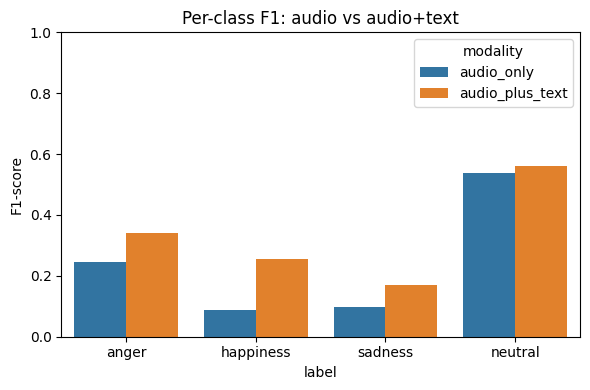


Per-class F1 comparison (audio vs audio+text):
           F1_audio  F1_audio+text  Delta (text - audio)
label                                                   
anger         0.246          0.340                 0.094
happiness     0.089          0.254                 0.165
sadness       0.096          0.171                 0.075
neutral       0.539          0.562                 0.023

Sample-level correctness breakdown:
  Both correct           : 426
  Audio only correct     : 8
  Audio+text only correct: 58
  Both wrong             : 593


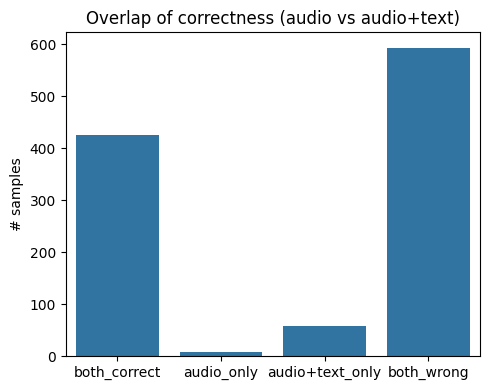


# samples where transcript FIXED an error: 58
label
happiness    29
anger        17
sadness       9
neutral       3
Name: count, dtype: int64 

# samples where transcript BROKE a correct prediction: 8
label
neutral    6
anger      2
Name: count, dtype: int64 



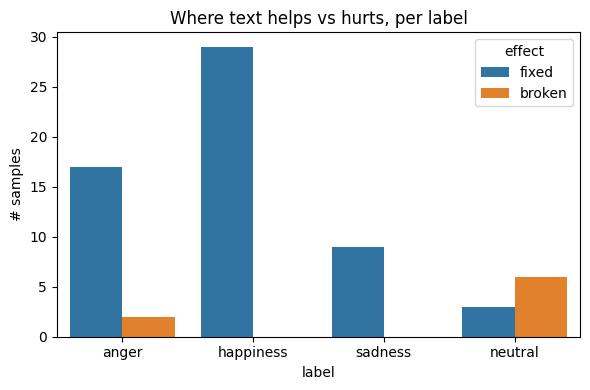

In [22]:
# ============================================
# 12. DEEPER ERROR ANALYSIS (NO GENDER YET)
# ============================================

from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# y_true, y_a, y_b already defined
# LABEL_LIST defined earlier

def clf_report_df(y_true, y_pred, labels, modality):
    rep = classification_report(
        y_true, y_pred, labels=labels, output_dict=True, zero_division=0
    )
    df = pd.DataFrame(rep).T
    df = df.loc[labels, ["precision", "recall", "f1-score"]]
    df["label"] = df.index
    df["modality"] = modality
    return df

rep_a = clf_report_df(y_true, y_a, LABEL_LIST, "audio_only")
rep_b = clf_report_df(y_true, y_b, LABEL_LIST, "audio_plus_text")

df_rep = pd.concat([rep_a, rep_b], ignore_index=True)
df_rep_melt = df_rep.melt(
    id_vars=["label", "modality"],
    value_vars=["precision", "recall", "f1-score"],
    var_name="metric",
    value_name="value",
)

# --- barplot only for F1 (cleaner & avoids wrong args) ---
plt.figure(figsize=(6, 4))
sns.barplot(
    data=df_rep_melt[df_rep_melt["metric"] == "f1-score"],
    x="label",
    y="value",
    hue="modality",
)
plt.ylim(0, 1)
plt.title("Per-class F1: audio vs audio+text")
plt.ylabel("F1-score")
plt.tight_layout()
plt.show()

# numeric table of F1 deltas
f1_a = rep_a.set_index("label")["f1-score"]
f1_b = rep_b.set_index("label")["f1-score"]
df_f1_delta = pd.DataFrame({
    "F1_audio": f1_a,
    "F1_audio+text": f1_b,
    "Delta (text - audio)": f1_b - f1_a,
})
print("\nPer-class F1 comparison (audio vs audio+text):")
print(df_f1_delta.round(3))


# --- sample-level correctness breakdown ---
y_true_arr = np.array(y_true)
y_a_arr    = np.array(y_a)
y_b_arr    = np.array(y_b)

correct_a = (y_a_arr == y_true_arr)
correct_b = (y_b_arr == y_true_arr)

df_eval["correct_audio"]   = correct_a
df_eval["correct_bimodal"] = correct_b

both_correct         = np.sum(correct_a & correct_b)
audio_only_correct   = np.sum(correct_a & ~correct_b)
bimodal_only_correct = np.sum(~correct_a & correct_b)
both_wrong           = np.sum(~correct_a & ~correct_b)

print("\nSample-level correctness breakdown:")
print(f"  Both correct           : {both_correct}")
print(f"  Audio only correct     : {audio_only_correct}")
print(f"  Audio+text only correct: {bimodal_only_correct}")
print(f"  Both wrong             : {both_wrong}")

plt.figure(figsize=(5, 4))
sns.barplot(
    x=["both_correct", "audio_only", "audio+text_only", "both_wrong"],
    y=[both_correct, audio_only_correct, bimodal_only_correct, both_wrong],
)
plt.ylabel("# samples")
plt.title("Overlap of correctness (audio vs audio+text)")
plt.tight_layout()
plt.show()


# --- where text fixes vs breaks errors, per label ---

fixed_mask  = (~correct_a) & correct_b
broken_mask = correct_a & (~correct_b)

fixed_labels  = df_eval.loc[fixed_mask, "label"]
broken_labels = df_eval.loc[broken_mask, "label"]

print("\n# samples where transcript FIXED an error:", fixed_labels.shape[0])
print(fixed_labels.value_counts(), "\n")

print("# samples where transcript BROKE a correct prediction:", broken_labels.shape[0])
print(broken_labels.value_counts(), "\n")

df_fb = pd.DataFrame({
    "label": LABEL_LIST,
    "fixed":  [ (fixed_labels == lab).sum()  for lab in LABEL_LIST ],
    "broken": [ (broken_labels == lab).sum() for lab in LABEL_LIST ],
})
df_fb_melt = df_fb.melt(id_vars="label", var_name="effect", value_name="count")

plt.figure(figsize=(6, 4))
sns.barplot(data=df_fb_melt, x="label", y="count", hue="effect")
plt.title("Where text helps vs hurts, per label")
plt.ylabel("# samples")
plt.tight_layout()
plt.show()


In [28]:
# --- ADD GENDER COLUMN FROM IEMOCAP utt_id ---

def infer_gender_from_utt(utt: str) -> str:
    if not isinstance(utt, str):
        return "unknown"
    try:
        sess = utt.split("_")[0]   # e.g. 'Ses01F' or 'Ses02M'
        g = sess[-1]
        if g == "F":
            return "female"
        elif g == "M":
            return "male"
        else:
            return "unknown"
    except Exception:
        return "unknown"

df_eval["gender"] = df_eval["utt_id"].apply(infer_gender_from_utt)

print("Gender distribution in df_eval:")
print(df_eval["gender"].value_counts())


Gender distribution in df_eval:
gender
male      578
female    507
Name: count, dtype: int64


Using gender column: gender
gender
male      578
female    507
Name: count, dtype: int64 

Global metrics by gender & modality:
metric                  Accuracy  Balanced Acc  Macro F1
gender modality                                         
female audio_only          0.495         0.319     0.287
       audio_plus_text     0.533         0.371     0.371
male   audio_only          0.317         0.298     0.205
       audio_plus_text     0.370         0.350     0.298


/tmp/ipython-input-3357932916.py:64: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_gender, x="metric", y="score", hue="modality", ci=None)


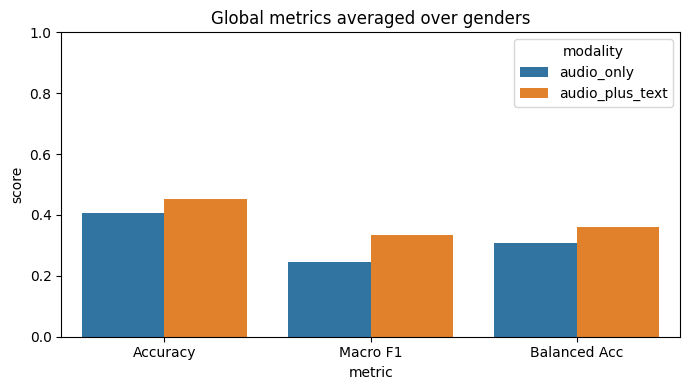


Per-class F1 by gender & modality (head):
   gender      label         modality     F1
0  female      anger       audio_only  0.232
1  female      anger  audio_plus_text  0.364
2  female  happiness       audio_only  0.143
3  female  happiness  audio_plus_text  0.259
4  female    sadness       audio_only  0.133


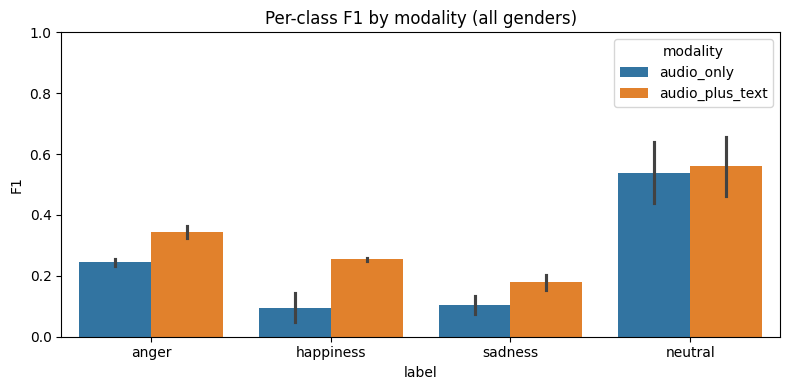

/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)


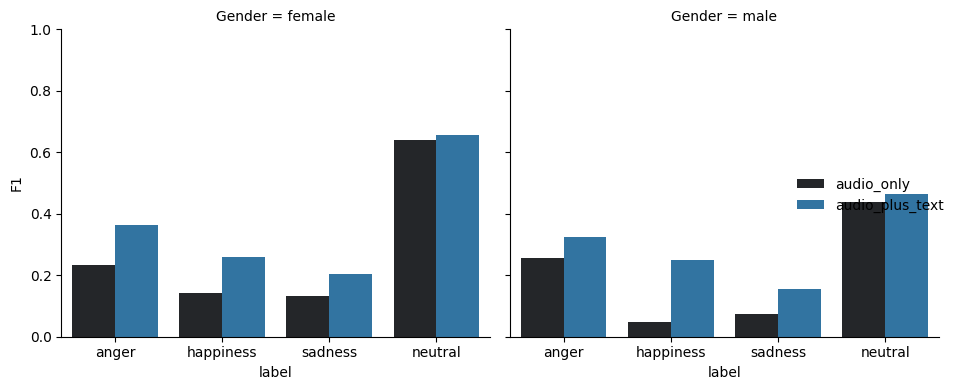

In [29]:
# ============================================
# 13. GENDER-BASED METRIC COMPARISON
# ============================================

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    balanced_accuracy_score,
    classification_report,
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# find which column to use
possible_gender_cols = ["gender", "speaker_gender", "sex"]
GENDER_COL = None
for c in possible_gender_cols:
    if c in df_eval.columns:
        GENDER_COL = c
        break

if GENDER_COL is None:
    raise ValueError(
        "No gender column found in df_eval; add one (e.g., 'gender') before running this cell."
    )

print(f"Using gender column: {GENDER_COL}")
print(df_eval[GENDER_COL].value_counts(), "\n")

def global_scores(y_true, y_pred):
    return {
        "Accuracy":      accuracy_score(y_true, y_pred),
        "Macro F1":      f1_score(y_true, y_pred, average="macro"),
        "Balanced Acc":  balanced_accuracy_score(y_true, y_pred),
    }

# ---------- global metrics per gender ----------
rows = []
for g in sorted(df_eval[GENDER_COL].unique()):
    mask = df_eval[GENDER_COL] == g
    y_true_g = df_eval.loc[mask, "label"].tolist()
    y_a_g    = df_eval.loc[mask, "pred_audio"].tolist()
    y_b_g    = df_eval.loc[mask, "pred_bimodal"].tolist()

    s_audio = global_scores(y_true_g, y_a_g)
    s_both  = global_scores(y_true_g, y_b_g)

    for metric, val in s_audio.items():
        rows.append({"gender": g, "modality": "audio_only", "metric": metric, "score": val})
    for metric, val in s_both.items():
        rows.append({"gender": g, "modality": "audio_plus_text", "metric": metric, "score": val})

df_gender = pd.DataFrame(rows)

print("Global metrics by gender & modality:")
print(
    df_gender.pivot_table(index=["gender", "modality"],
                          columns="metric",
                          values="score").round(3)
)

plt.figure(figsize=(7, 4))
sns.barplot(data=df_gender, x="metric", y="score", hue="modality", ci=None)
plt.ylim(0, 1)
plt.title("Global metrics averaged over genders")
plt.tight_layout()
plt.show()

# ---------- per-class F1 by gender & modality ----------
rows = []
for g in sorted(df_eval[GENDER_COL].unique()):
    mask = df_eval[GENDER_COL] == g
    y_true_g = df_eval.loc[mask, "label"].tolist()
    y_a_g    = df_eval.loc[mask, "pred_audio"].tolist()
    y_b_g    = df_eval.loc[mask, "pred_bimodal"].tolist()

    rep_a_g = classification_report(
        y_true_g, y_a_g, labels=LABEL_LIST,
        output_dict=True, zero_division=0
    )
    rep_b_g = classification_report(
        y_true_g, y_b_g, labels=LABEL_LIST,
        output_dict=True, zero_division=0
    )

    for lab in LABEL_LIST:
        rows.append({
            "gender": g,
            "label": lab,
            "modality": "audio_only",
            "F1": rep_a_g[lab]["f1-score"],
        })
        rows.append({
            "gender": g,
            "label": lab,
            "modality": "audio_plus_text",
            "F1": rep_b_g[lab]["f1-score"],
        })

df_gender_f1 = pd.DataFrame(rows)

print("\nPer-class F1 by gender & modality (head):")
print(df_gender_f1.head().round(3))

# aggregated over genders
plt.figure(figsize=(8, 4))
sns.barplot(
    data=df_gender_f1,
    x="label",
    y="F1",
    hue="modality",
)
plt.ylim(0, 1)
plt.title("Per-class F1 by modality (all genders)")
plt.tight_layout()
plt.show()

# separate panels per gender
g = sns.FacetGrid(df_gender_f1, col="gender", height=4, sharey=True)
g.map_dataframe(sns.barplot, x="label", y="F1", hue="modality")
g.add_legend()
g.set_titles(col_template="Gender = {col_name}")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
